First we want to simulate the case of $P_t = P_t^f + B_t$ where $P_t^f$ is a random walk, and $B_t > 0$ in some periods of the simulation.

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

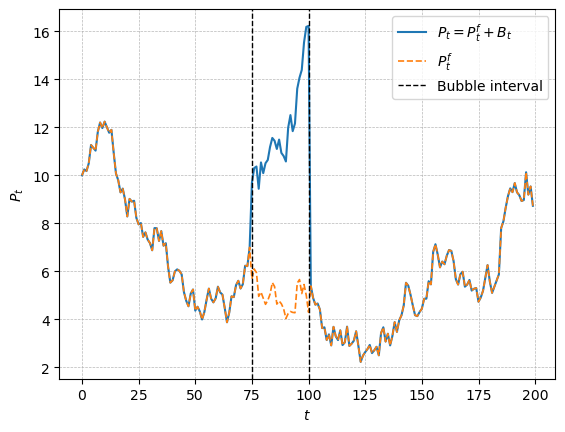

In [26]:
# Seed
np.random.seed(42)

# Parameters
T = 200
mu_f = 0.0    # if positive, random walk with drift, if zero, pure random walk
sigma_f = 0.5
R = 0.04
sigma_b = 0.5
t_start = 75 # bubble starts here
t_end   = 100 # bubble ends here

# Empty arrays
Pf = np.zeros(T)
B  = np.zeros(T)
P  = np.zeros(T)

# Initial prices
P[0] = 10
Pf[0] = 10
B0 = 4      # positive value means bubble starts above fundamental price

# Loop
for t in range(1, T):

    # Fundamental
    Pf[t] = Pf[t-1] + mu_f + np.random.normal(0, sigma_f)

    # Bubble
    if t < t_start:
        B[t] = 0

    elif t == t_start:
        B[t] = B0

    elif t_start < t <= t_end:
        B[t] = (1 + R) * B[t-1] + np.random.normal(0, sigma_b)
        B[t] = max(B[t], 0)

    else:
        B[t] = 0

    P[t] = Pf[t] + B[t]

# Plotting
plt.plot(P, label=r"$P_t = P_t^f +  B_t$")
plt.plot(Pf, label=r"$P_t^f$", linestyle="--", lw=1.2)
# plt.plot(B, label=r"$B_t$")
plt.axvline(t_start, linestyle="--", linewidth=1, label="Bubble interval", color="black")
plt.axvline(t_end, linestyle="--", linewidth=1, color="black")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.9)
plt.xlabel("$t$")
plt.ylabel("$P_t$")
plt.legend()
plt.savefig("bubble_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

Now we want to test...

In [6]:
# --- ADF (no intercept, no lags): ΔP_t = π P_{t-1} + ε_t ---

dP = P[1:]              # ΔP_t = P_t - P_{t-1}
P_lag = P[:-1]          # P_{t-1}
T_reg = len(dP)         # T_reg = T - 1, since we lose one observation due to differencing

# OLS estimate: pi_hat = (X'Y)/(X'X)
X = P_lag
Y = dP

pi_hat = np.dot(X, Y) / np.dot(X, X)

# residuals and variance
resid = Y - pi_hat * X
s2 = np.dot(resid, resid) / (T_reg - 1)      # df = T_reg - k, k=1
se_pi = np.sqrt(s2 / np.dot(X, X))

t_stat = pi_hat / se_pi

# right-tailed p-value using t distribution (approx; ADF has nonstandard crit vals)
pval_right_t = 1 - stats.t.cdf(t_stat, df=T_reg - 1)

print(f"pi_hat = {pi_hat:.6f}")
print(f"se(pi) = {se_pi:.6f}")
print(f"t-stat = {t_stat:.3f}")
print(f"Right-tailed p-value (t approx) = {pval_right_t:.4f}")

pi_hat = 0.998361
se(pi) = 0.004560
t-stat = 218.920
Right-tailed p-value (t approx) = 0.0000


In [7]:
def df_right_tail_no_intercept(series, name="series"):
    """
    DF/ADF with k=0 and NO intercept:
        Δx_t = π x_{t-1} + ε_t
    Tests H0: π = 0 vs H1: π > 0 (right-tailed), p-value is t-approx.
    """
    dx = np.diff(series)      # Δx_t
    x_lag = series[:-1]       # x_{t-1}
    T_reg = len(dx)

    X = x_lag
    Y = dx

    # OLS pi_hat
    pi_hat = np.dot(X, Y) / np.dot(X, X)

    # SE(pi_hat)
    resid = Y - pi_hat * X
    s2 = np.dot(resid, resid) / (T_reg - 1)      # df = T_reg - 1 (k=1 regressor)
    se_pi = np.sqrt(s2 / np.dot(X, X))

    t_stat = pi_hat / se_pi
    pval_right_t = 1 - stats.t.cdf(t_stat, df=T_reg - 1)

    print(f"\n--- DF (no intercept, no lags) on {name} ---")
    print(f"pi_hat = {pi_hat:.6f}")
    print(f"se(pi) = {se_pi:.6f}")
    print(f"t-stat = {t_stat:.3f}")
    print(f"Right-tailed p-value (t approx) = {pval_right_t:.4f}")

    return pi_hat, se_pi, t_stat, pval_right_t

# Run on both series
df_right_tail_no_intercept(P,  name="P_t")
df_right_tail_no_intercept(Pf, name="P_t^f")


--- DF (no intercept, no lags) on P_t ---
pi_hat = -0.001639
se(pi) = 0.004560
t-stat = -0.359
Right-tailed p-value (t approx) = 0.6402

--- DF (no intercept, no lags) on P_t^f ---
pi_hat = -0.001349
se(pi) = 0.004324
t-stat = -0.312
Right-tailed p-value (t approx) = 0.6223


(np.float64(-0.001348945407773355),
 np.float64(0.004323781949310518),
 np.float64(-0.31198275574198686),
 np.float64(0.6223090431942715))